In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls

drive/  sample_data/


In [3]:
# Step 1: Copy the entire project folder to local storage
!cp -r /content/drive/MyDrive/25t1-9517 /content/

In [4]:
# Step 2: Validating replication results
!ls /content/25t1-9517

Aerial_Landscapes  __pycache__	src


In [5]:
# Step 4: Update data path (for subsequent code)
data_dir = '/content/Aerial_Landscapes'

In [6]:
ls


25t1-9517/  drive/  sample_data/


In [7]:
cd 25t1-9517

/content/25t1-9517


In [8]:
ls

Aerial_Landscapes/  __pycache__/  src/


In [9]:
!find . -type f | wc -l

12019


In [10]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-uoxb751c
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-uoxb751c
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.

# **Deeplearning Method**

In [11]:
# Import modules (using src/DL path)
import sys
sys.path.append('/content/25t1-9517/src/DL')  # Add the src/DL path to Python path

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from aerial_data_loader import get_data_loaders
from aerial_model_factory import get_resnet18, get_mobilenetv3_small
from aerial_training_utils import train_model, evaluate_model
from aerial_occlusion_test import evaluate_with_occlusion
from aerial_scorecam import get_scorecam_heatmap

In [12]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

CUDA Available: True
GPU Name: NVIDIA L4


**Step 1 Loading and pre-processing data**

In [14]:
# Step 1: Load and Preprocess Data (Using Local Path)
data_dir = '/content/25t1-9517/Aerial_Landscapes'  # Use local path
batch_size = 64  # Set to 64 to utilize GPU efficiently
train_ratio = 0.8
sample_ratio = 1

train_loader1, train_loader2, test_loader = get_data_loaders(data_dir, batch_size, train_ratio, sample_ratio)
print("Data loaded successfully.")

# Get class names
class_names = test_loader.dataset.dataset.classes
print(f"Class names: {class_names}")

# Initialize results list
all_results = []

Data loaded successfully.
Class names: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


**step 2 Train models on Balanced Dataset**

In [15]:
print(f"Training samples: {len(train_loader1.dataset)}")
print(f"Number of batches: {len(train_loader1)}")

Training samples: 9600
Number of batches: 150


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 231MB/s]


Training Model 1 (ResNet-18, No CutMix)...


Epoch 1/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 0.6683, Train Accuracy: 82.51, Train IoU: 0.000, Test Accuracy: 81.75, Test IoU: 0.000


Epoch 2/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 2/5, Train loss: 0.3801, Train Accuracy: 88.86, Train IoU: 0.000, Test Accuracy: 87.33, Test IoU: 0.000


Epoch 3/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 3/5, Train loss: 0.3196, Train Accuracy: 86.24, Train IoU: 0.000, Test Accuracy: 85.04, Test IoU: 0.000


Epoch 4/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 4/5, Train loss: 0.2575, Train Accuracy: 90.43, Train IoU: 0.000, Test Accuracy: 88.75, Test IoU: 0.000


Epoch 5/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 5/5, Train loss: 0.2511, Train Accuracy: 86.69, Train IoU: 0.000, Test Accuracy: 85.58, Test IoU: 0.000
Best Test Accuracy: 88.75%
Training Time: 799.99 seconds
Classification Report (Model 1 Baseline (No Occlusion)):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.817708  0.981250  0.892045   160.000000  0.805128    0.251110
Airport        0.800000  0.700000  0.746667   160.000000  0.595745    0.251110
Beach          0.985075  0.825000  0.897959   160.000000  0.814815    0.251110
City           0.777778  0.875000  0.823529   160.000000  0.700000    0.251110
Desert         0.935484  0.906250  0.920635   160.000000  0.852941    0.251110
Forest         0.832432  0.962500  0.892754   160.000000  0.806283    0.251110
Grassland      0.914634  0.937500  0.925926   160.000000  0.862069    0.251110
Highway        0.929825  0.662500  0.773723   160.000000  0.630952    0.251110
Lake           0.899408  0.950000  0.924012   160.000000  0.85875

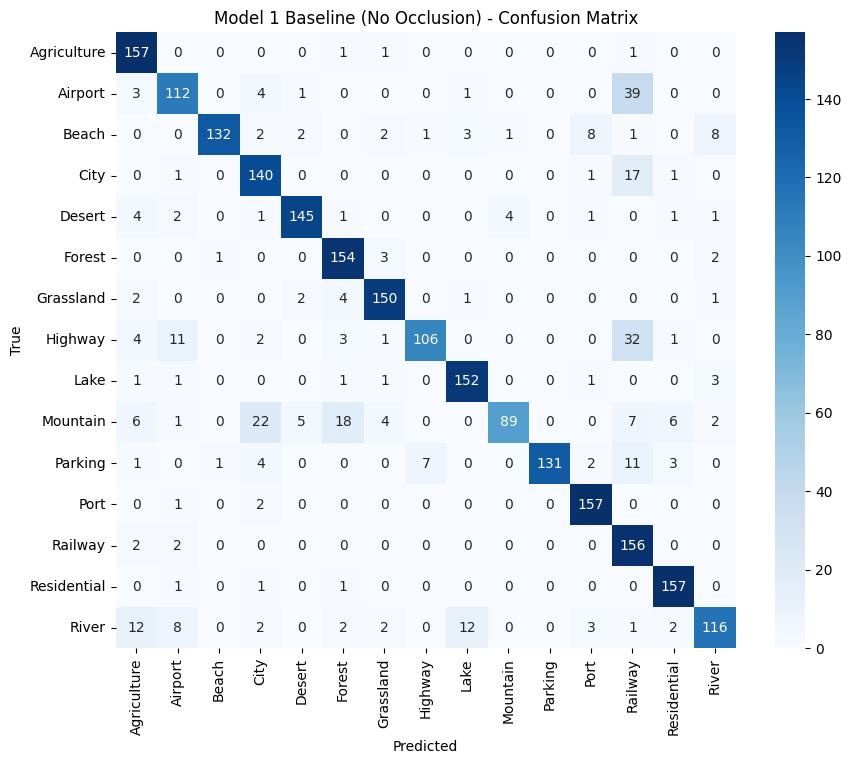

Model 1 Baseline (No Occlusion): Accuracy=85.58%, F1=0.85, Precision=0.88, Recall=0.86, IoU=0.754, Train loss=0.251


In [16]:
# Step 2: Train Models on Balanced Dataset
# Model 1: ResNet-18, without CutMix (Standard Augmentation: Flip, Crop, Color Jitter)
model1 = get_resnet18(num_classes=15).to(device)
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
print("Training Model 1 (ResNet-18, No CutMix)...")
best_acc1, training_time1, train_loss1 = train_model(model1, train_loader1, test_loader, criterion, optimizer1, device, epochs=5, use_cutmix=False)

# Evaluate Model 1 on the test set (before occlusion)
acc1_base, f1_1_base, prec1_base, rec1_base, iou1_base, preds1, labels1 = evaluate_model(model1, test_loader, device, class_names=class_names, scenario="Model 1 Baseline (No Occlusion)", train_loss=train_loss1)
print(f"Model 1 Baseline (No Occlusion): Accuracy={acc1_base:.2f}%, F1={f1_1_base:.2f}, Precision={prec1_base:.2f}, Recall={rec1_base:.2f}, IoU={iou1_base:.3f}, Train loss={train_loss1:.3f}")

In [17]:
print(f"Training samples: {len(train_loader1.dataset)}")
print(f"Number of batches: {len(train_loader1)}")

Training samples: 9600
Number of batches: 150


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Model 2 (ResNet-18, With CutMix)...


Epoch 1/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 1.0452, Train Accuracy: 77.02, Train IoU: 0.000, Test Accuracy: 75.58, Test IoU: 0.000


Epoch 2/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 2/5, Train loss: 0.8432, Train Accuracy: 91.52, Train IoU: 0.000, Test Accuracy: 89.08, Test IoU: 0.000


Epoch 3/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 3/5, Train loss: 0.7233, Train Accuracy: 91.86, Train IoU: 0.000, Test Accuracy: 90.46, Test IoU: 0.000


Epoch 4/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 4/5, Train loss: 0.6860, Train Accuracy: 93.79, Train IoU: 0.000, Test Accuracy: 89.62, Test IoU: 0.000


Epoch 5/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 5/5, Train loss: 0.6828, Train Accuracy: 94.35, Train IoU: 0.000, Test Accuracy: 91.71, Test IoU: 0.000
Best Test Accuracy: 91.71%
Training Time: 314.08 seconds
Classification Report (Model 2 Baseline (No Occlusion)):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.956522  0.962500  0.959502   160.000000  0.922156    0.682777
Airport        0.816993  0.781250  0.798722   160.000000  0.664894    0.682777
Beach          0.960784  0.918750  0.939297   160.000000  0.885542    0.682777
City           0.951724  0.862500  0.904918   160.000000  0.826347    0.682777
Desert         0.973333  0.912500  0.941935   160.000000  0.890244    0.682777
Forest         0.955414  0.937500  0.946372   160.000000  0.898204    0.682777
Grassland      0.895954  0.968750  0.930931   160.000000  0.870787    0.682777
Highway        0.880000  0.962500  0.919403   160.000000  0.850829    0.682777
Lake           0.947712  0.906250  0.926518   160.000000  0.86309

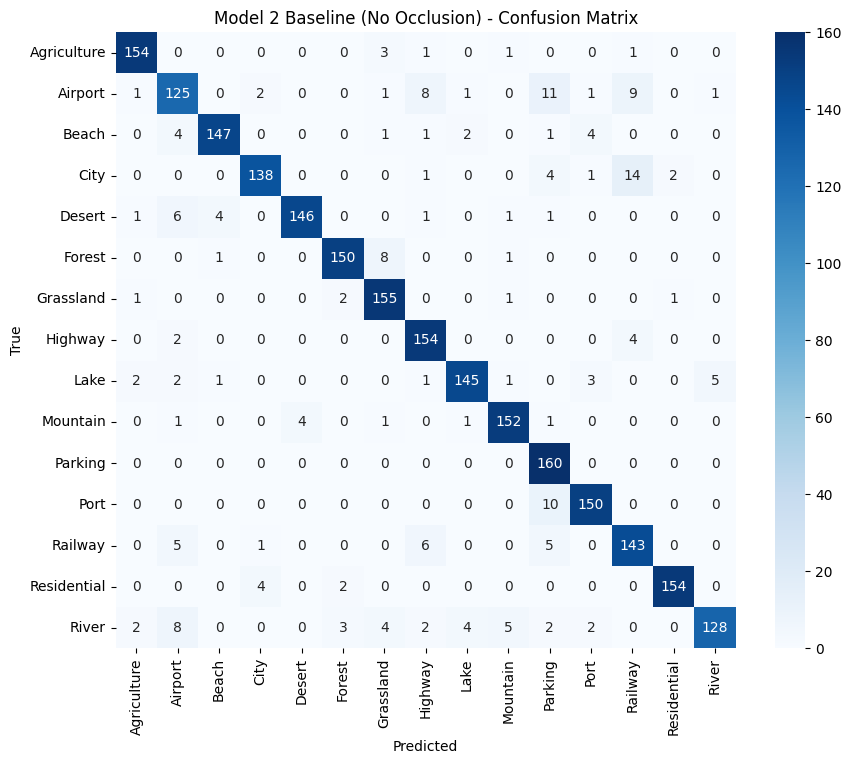

Model 2 Baseline (No Occlusion): Accuracy=91.71%, F1=0.92, Precision=0.92, Recall=0.92, IoU=0.849, Train loss=0.683


In [18]:
# Model 2: ResNet-18, with CutMix (Random Rotation)
model2 = get_resnet18(num_classes=15).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
print("Training Model 2 (ResNet-18, With CutMix)...")
best_acc2, training_time2, train_loss2 = train_model(model2, train_loader2, test_loader, criterion, optimizer2, device, epochs=5, use_cutmix=True)

# Evaluate Model 2 on the test set (before occlusion)
acc2_base, f1_2_base, prec2_base, rec2_base, iou2_base, preds2, labels2 = evaluate_model(model2, test_loader, device, class_names=class_names, scenario="Model 2 Baseline (No Occlusion)", train_loss=train_loss2)
print(f"Model 2 Baseline (No Occlusion): Accuracy={acc2_base:.2f}%, F1={f1_2_base:.2f}, Precision={prec2_base:.2f}, Recall={rec2_base:.2f}, IoU={iou2_base:.3f}, Train loss={train_loss2:.3f}")

In [19]:
print(f"Training samples: {len(train_loader1.dataset)}")
print(f"Number of batches: {len(train_loader1)}")

Training samples: 9600
Number of batches: 150


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 184MB/s]

Training Model 3 (MobileNetV3-Small, No CutMix)...


Epoch 1/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 0.4303, Train Accuracy: 87.50, Train IoU: 0.000, Test Accuracy: 85.38, Test IoU: 0.000


Epoch 2/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 2/5, Train loss: 0.1666, Train Accuracy: 93.67, Train IoU: 0.000, Test Accuracy: 91.54, Test IoU: 0.000


Epoch 3/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 3/5, Train loss: 0.1299, Train Accuracy: 96.16, Train IoU: 0.000, Test Accuracy: 93.75, Test IoU: 0.000


Epoch 4/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 4/5, Train loss: 0.1110, Train Accuracy: 95.93, Train IoU: 0.000, Test Accuracy: 93.75, Test IoU: 0.000


Epoch 5/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 5/5, Train loss: 0.1007, Train Accuracy: 97.00, Train IoU: 0.000, Test Accuracy: 95.12, Test IoU: 0.000
Best Test Accuracy: 95.12%
Training Time: 753.25 seconds
Classification Report (Model 3 Baseline (No Occlusion)):
              precision   recall  f1-score     support       iou  train_loss
Agriculture    0.888889  1.00000  0.941176   160.00000  0.888889    0.100708
Airport        0.911765  0.96875  0.939394   160.00000  0.885714    0.100708
Beach          0.992647  0.84375  0.912162   160.00000  0.838509    0.100708
City           0.956790  0.96875  0.962733   160.00000  0.928144    0.100708
Desert         0.986928  0.94375  0.964856   160.00000  0.932099    0.100708
Forest         0.972973  0.90000  0.935065   160.00000  0.878049    0.100708
Grassland      0.886364  0.97500  0.928571   160.00000  0.866667    0.100708
Highway        1.000000  0.93750  0.967742   160.00000  0.937500    0.100708
Lake           0.937888  0.94375  0.940810   160.00000  0.888235    0.100708
Mounta

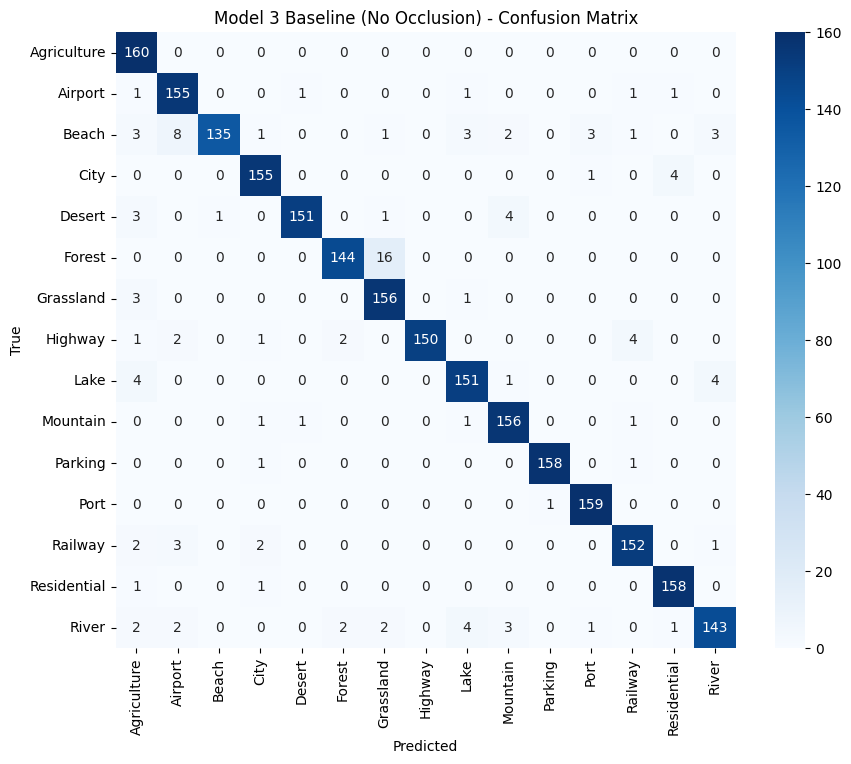

Model 3 Baseline (No Occlusion): Accuracy=95.12%, F1=0.95, Precision=0.95, Recall=0.95, IoU=0.908, Train loss=0.101


In [20]:
# Model 3: MobileNetV3-Small, without CutMix (Standard Augmentation: Flip, Crop, Color Jitter)
model3 = get_mobilenetv3_small(num_classes=15).to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
print("Training Model 3 (MobileNetV3-Small, No CutMix)...")
best_acc3, training_time3, train_loss3 = train_model(model3, train_loader1, test_loader, criterion, optimizer3, device, epochs=5, use_cutmix=False)

# Evaluate Model 3 on the test set (before occlusion)
acc3_base, f1_3_base, prec3_base, rec3_base, iou3_base, preds3, labels3 = evaluate_model(model3, test_loader, device, class_names=class_names, scenario="Model 3 Baseline (No Occlusion)", train_loss=train_loss3)
print(f"Model 3 Baseline (No Occlusion): Accuracy={acc3_base:.2f}%, F1={f1_3_base:.2f}, Precision={prec3_base:.2f}, Recall={rec3_base:.2f}, IoU={iou3_base:.3f}, Train loss={train_loss3:.3f}")

In [21]:
print(f"Training samples: {len(train_loader1.dataset)}")
print(f"Number of batches: {len(train_loader1)}")

Training samples: 9600
Number of batches: 150


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Model 4 (MobileNetV3-Small, With CutMix)...


Epoch 1/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 0.8428, Train Accuracy: 76.77, Train IoU: 0.000, Test Accuracy: 84.75, Test IoU: 0.000


Epoch 2/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 2/5, Train loss: 0.6202, Train Accuracy: 95.98, Train IoU: 0.000, Test Accuracy: 94.46, Test IoU: 0.000


Epoch 3/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 3/5, Train loss: 0.6239, Train Accuracy: 94.07, Train IoU: 0.000, Test Accuracy: 93.33, Test IoU: 0.000


Epoch 4/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 4/5, Train loss: 0.5741, Train Accuracy: 95.82, Train IoU: 0.000, Test Accuracy: 94.00, Test IoU: 0.000


Epoch 5/5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 5/5, Train loss: 0.5454, Train Accuracy: 95.33, Train IoU: 0.000, Test Accuracy: 93.33, Test IoU: 0.000
Best Test Accuracy: 94.46%
Training Time: 239.00 seconds
Classification Report (Model 4 Baseline (No Occlusion)):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.912281  0.975000  0.942598   160.000000  0.891429    0.545421
Airport        0.903030  0.931250  0.916923   160.000000  0.846591    0.545421
Beach          0.969512  0.993750  0.981481   160.000000  0.963636    0.545421
City           0.968750  0.968750  0.968750   160.000000  0.939394    0.545421
Desert         0.845745  0.993750  0.913793   160.000000  0.841270    0.545421
Forest         0.922078  0.887500  0.904459   160.000000  0.825581    0.545421
Grassland      0.762136  0.981250  0.857923   160.000000  0.751196    0.545421
Highway        1.000000  0.843750  0.915254   160.000000  0.843750    0.545421
Lake           0.985507  0.850000  0.912752   160.000000  0.83950

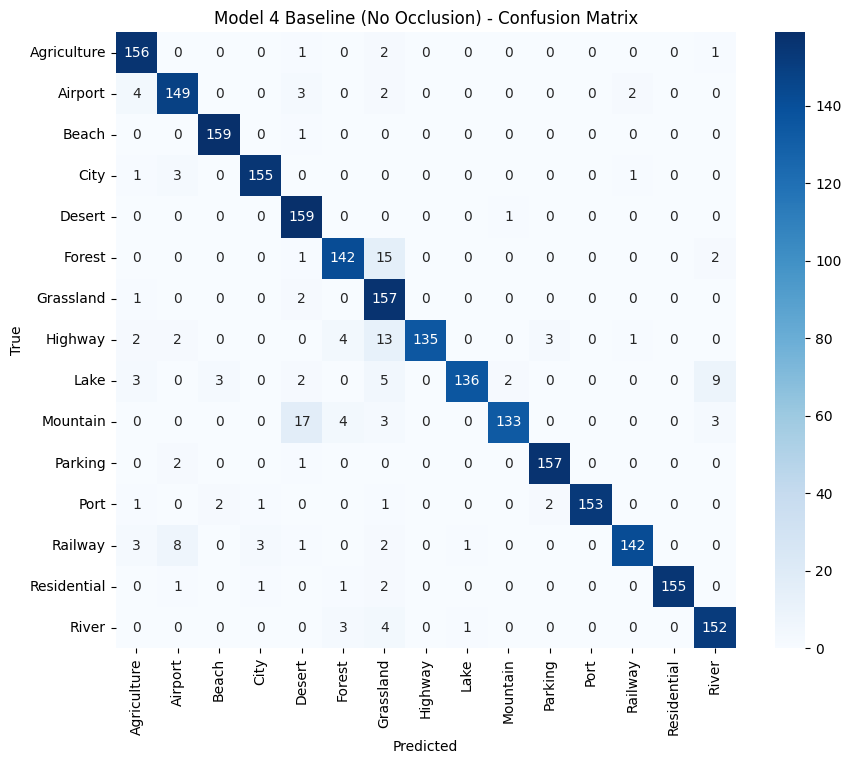

Model 4 Baseline (No Occlusion): Accuracy=93.33%, F1=0.93, Precision=0.94, Recall=0.93, IoU=0.878, Train loss=0.545


In [22]:
# Model 4: MobileNetV3-Small, with CutMix (Random Rotation)
model4 = get_mobilenetv3_small(num_classes=15).to(device)
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)
print("Training Model 4 (MobileNetV3-Small, With CutMix)...")
best_acc4, training_time4, train_loss4 = train_model(model4, train_loader2, test_loader, criterion, optimizer4, device, epochs=5, use_cutmix=True)

# Evaluate Model 4 on the test set (before occlusion)
acc4_base, f1_4_base, prec4_base, rec4_base, iou4_base, preds4, labels4 = evaluate_model(model4, test_loader, device, class_names=class_names, scenario="Model 4 Baseline (No Occlusion)", train_loss=train_loss4)
print(f"Model 4 Baseline (No Occlusion): Accuracy={acc4_base:.2f}%, F1={f1_4_base:.2f}, Precision={prec4_base:.2f}, Recall={rec4_base:.2f}, IoU={iou4_base:.3f}, Train loss={train_loss4:.3f}")


**Step 2.5: Imbalanced Dataset Experiment**

In [23]:
# Step 2.5: Imbalanced Dataset Experiment
print("\n=== Imbalanced Dataset Experiment ===")

# Load imbalanced dataset
train_loader1_imbalance, train_loader2_imbalance, test_loader_imbalance = get_data_loaders(data_dir, batch_size, train_ratio, sample_ratio, imbalance=True)
print("Imbalanced data loaded successfully.")


=== Imbalanced Dataset Experiment ===
Imbalanced data loaded successfully.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Model 1 (ResNet-18, No CutMix) on imbalanced dataset...


Epoch 1/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 0.7070, Train Accuracy: 74.01, Train IoU: 0.000, Test Accuracy: 65.38, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/5, Train loss: 0.4555, Train Accuracy: 83.42, Train IoU: 0.000, Test Accuracy: 71.83, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/5, Train loss: 0.3563, Train Accuracy: 82.64, Train IoU: 0.000, Test Accuracy: 71.83, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/5, Train loss: 0.2876, Train Accuracy: 88.21, Train IoU: 0.000, Test Accuracy: 79.42, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5, Train loss: 0.2674, Train Accuracy: 94.47, Train IoU: 0.000, Test Accuracy: 84.38, Test IoU: 0.000
Best Test Accuracy: 84.38%
Training Time: 412.70 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Classification Report (Model 1 Imbalanced):
              precision   recall  f1-score     support       iou  train_loss
Agriculture    0.796954  0.98125  0.879552   160.00000  0.785000    0.267402
Airport        0.786982  0.83125  0.808511   160.00000  0.678571    0.267402
Beach          0.896552  0.97500  0.934132   160.00000  0.876404    0.267402
City           0.721154  0.93750  0.815217   160.00000  0.688073    0.267402
Desert         0.967105  0.91875  0.942308   160.00000  0.890909    0.267402
Forest         0.889571  0.90625  0.897833   160.00000  0.814607    0.267402
Grassland      0.811518  0.96875  0.883191   160.00000  0.790816    0.267402
Highway        0.872727  0.90000  0.886154   160.00000  0.795580    0.267402
Lake           0.706977  0.95000  0.810667   160.00000  0.681614    0.267402
Mountain       0.757282  0.97500  0.852459   160.00000  0.742857    0.267402
Parking        1.000000  0.91250  0.954248   160.00000  0.912500    0.267402
Port           0.983871  0.76250

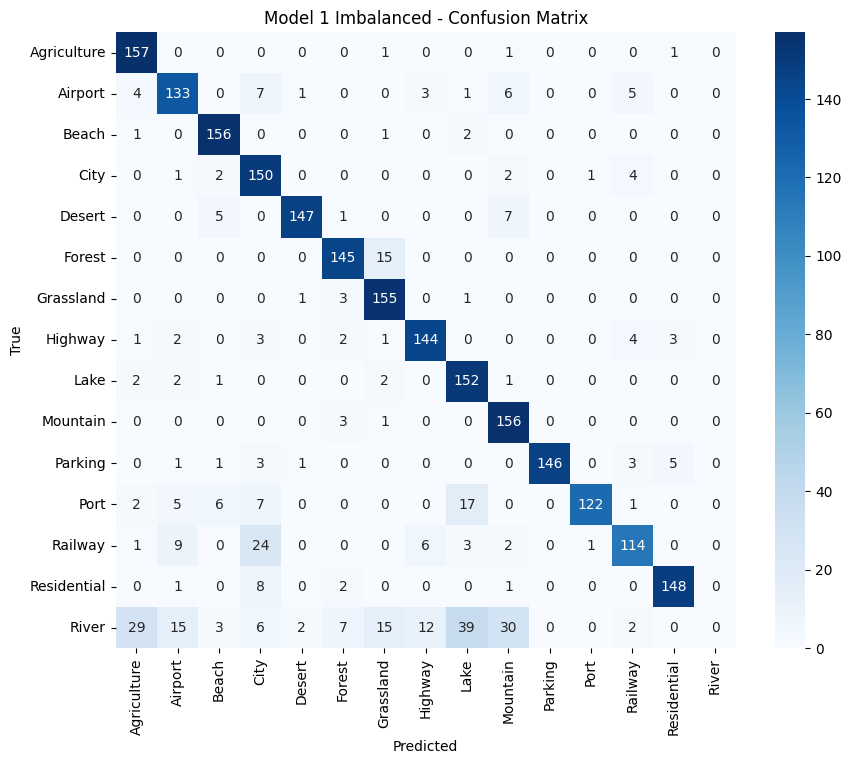

Model 1 Imbalanced: Accuracy=84.38%, F1=0.82, Precision=0.80, Recall=0.84, IoU=0.728, Train loss=0.267


In [24]:
# Train and evaluate models on imbalanced dataset
# Model 1: ResNet-18, without CutMix
model1_imbalance = get_resnet18(num_classes=15).to(device)
optimizer1_imbalance = optim.Adam(model1_imbalance.parameters(), lr=0.001)
print("Training Model 1 (ResNet-18, No CutMix) on imbalanced dataset...")
best_acc1_imbalance, training_time1_imbalance, train_loss1_imbalance = train_model(model1_imbalance, train_loader1_imbalance, test_loader_imbalance, criterion, optimizer1_imbalance, device, epochs=5, use_cutmix=False)

# Evaluate Model 1 on the test set (imbalanced)
acc1_imbalance, f1_1_imbalance, prec1_imbalance, rec1_imbalance, iou1_imbalance, preds1_imbalance, labels1_imbalance = evaluate_model(model1_imbalance, test_loader_imbalance, device, class_names=class_names, scenario="Model 1 Imbalanced", train_loss=train_loss1_imbalance)
print(f"Model 1 Imbalanced: Accuracy={acc1_imbalance:.2f}%, F1={f1_1_imbalance:.2f}, Precision={prec1_imbalance:.2f}, Recall={rec1_imbalance:.2f}, IoU={iou1_imbalance:.3f}, Train loss={train_loss1_imbalance:.3f}")

Training Model 2 (ResNet-18, With CutMix) on imbalanced dataset...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 1.1514, Train Accuracy: 85.67, Train IoU: 0.000, Test Accuracy: 68.33, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/5, Train loss: 0.9115, Train Accuracy: 86.57, Train IoU: 0.000, Test Accuracy: 72.50, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/5, Train loss: 0.7764, Train Accuracy: 90.97, Train IoU: 0.000, Test Accuracy: 76.46, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/5, Train loss: 0.6979, Train Accuracy: 93.51, Train IoU: 0.000, Test Accuracy: 81.33, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5, Train loss: 0.6564, Train Accuracy: 90.84, Train IoU: 0.000, Test Accuracy: 78.21, Test IoU: 0.000
Best Test Accuracy: 81.33%
Training Time: 172.17 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Classification Report (Model 2 Imbalanced):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.710145  0.918750  0.801090   160.000000  0.668182    0.656417
Airport        0.819048  0.537500  0.649057   160.000000  0.480447    0.656417
Beach          0.911392  0.900000  0.905660   160.000000  0.827586    0.656417
City           0.798913  0.918750  0.854651   160.000000  0.746193    0.656417
Desert         0.949686  0.943750  0.946708   160.000000  0.898810    0.656417
Forest         0.819209  0.906250  0.860534   160.000000  0.755208    0.656417
Grassland      0.587361  0.987500  0.736597   160.000000  0.583026    0.656417
Highway        0.616667  0.925000  0.740000   160.000000  0.587302    0.656417
Lake           0.741294  0.931250  0.825485   160.000000  0.702830    0.656417
Mountain       0.744565  0.856250  0.796512   160.000000  0.661836    0.656417
Parking        0.918750  0.918750  0.918750   160.000000  0.849711    0.656417
Port    

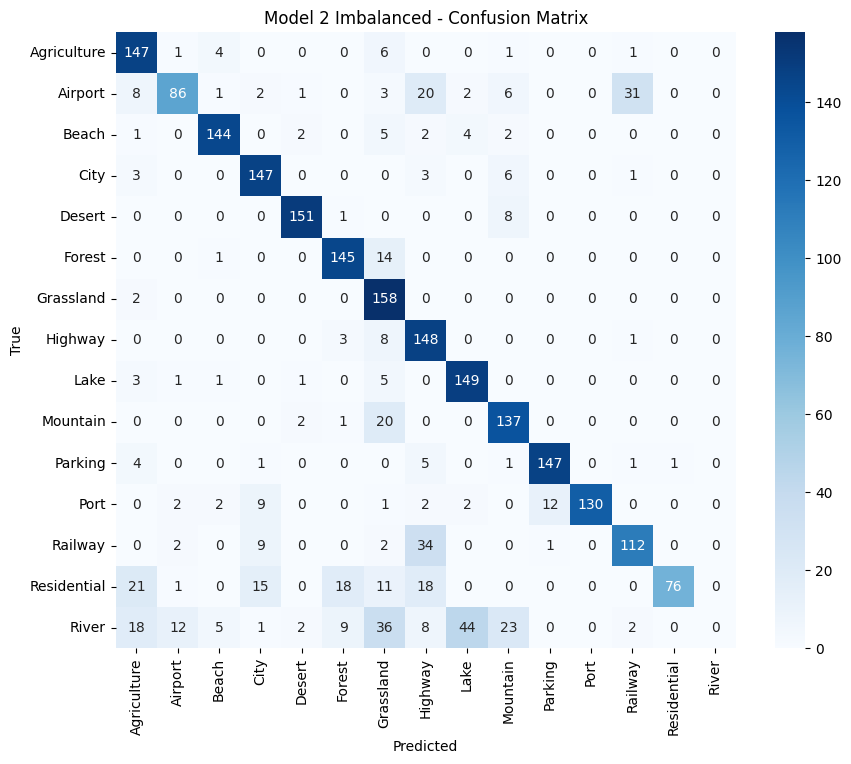

Model 2 Imbalanced: Accuracy=78.21%, F1=0.75, Precision=0.76, Recall=0.78, IoU=0.641, Train loss=0.656


In [25]:
# Model 2: ResNet-18, with CutMix
model2_imbalance = get_resnet18(num_classes=15).to(device)
optimizer2_imbalance = optim.Adam(model2_imbalance.parameters(), lr=0.001)
print("Training Model 2 (ResNet-18, With CutMix) on imbalanced dataset...")
best_acc2_imbalance, training_time2_imbalance, train_loss2_imbalance = train_model(model2_imbalance, train_loader2_imbalance, test_loader_imbalance, criterion, optimizer2_imbalance, device, epochs=5, use_cutmix=True)

# Evaluate Model 2 on the test set (imbalanced)
acc2_imbalance, f1_2_imbalance, prec2_imbalance, rec2_imbalance, iou2_imbalance, preds2_imbalance, labels2_imbalance = evaluate_model(model2_imbalance, test_loader_imbalance, device, class_names=class_names, scenario="Model 2 Imbalanced", train_loss=train_loss2_imbalance)
print(f"Model 2 Imbalanced: Accuracy={acc2_imbalance:.2f}%, F1={f1_2_imbalance:.2f}, Precision={prec2_imbalance:.2f}, Recall={rec2_imbalance:.2f}, IoU={iou2_imbalance:.3f}, Train loss={train_loss2_imbalance:.3f}")

Training Model 3 (MobileNetV3-Small, No CutMix) on imbalanced dataset...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 0.5258, Train Accuracy: 79.37, Train IoU: 0.000, Test Accuracy: 68.42, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/5, Train loss: 0.2019, Train Accuracy: 89.36, Train IoU: 0.000, Test Accuracy: 80.21, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/5, Train loss: 0.1009, Train Accuracy: 98.16, Train IoU: 0.000, Test Accuracy: 85.79, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/5, Train loss: 0.0898, Train Accuracy: 94.39, Train IoU: 0.000, Test Accuracy: 83.54, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5, Train loss: 0.1010, Train Accuracy: 96.33, Train IoU: 0.000, Test Accuracy: 84.25, Test IoU: 0.000
Best Test Accuracy: 85.79%
Training Time: 385.49 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Classification Report (Model 3 Imbalanced):
              precision   recall  f1-score    support       iou  train_loss
Agriculture    0.880952  0.92500  0.902439   160.0000  0.822222    0.100989
Airport        0.720812  0.88750  0.795518   160.0000  0.660465    0.100989
Beach          0.956790  0.96875  0.962733   160.0000  0.928144    0.100989
City           0.672269  1.00000  0.804020   160.0000  0.672269    0.100989
Desert         0.870787  0.96875  0.917160   160.0000  0.846995    0.100989
Forest         0.918605  0.98750  0.951807   160.0000  0.908046    0.100989
Grassland      0.992593  0.83750  0.908475   160.0000  0.832298    0.100989
Highway        0.834254  0.94375  0.885630   160.0000  0.794737    0.100989
Lake           0.615385  0.95000  0.746929   160.0000  0.596078    0.100989
Mountain       0.937063  0.83750  0.884488   160.0000  0.792899    0.100989
Parking        0.863636  0.95000  0.904762   160.0000  0.826087    0.100989
Port           0.913580  0.92500  0.919255  

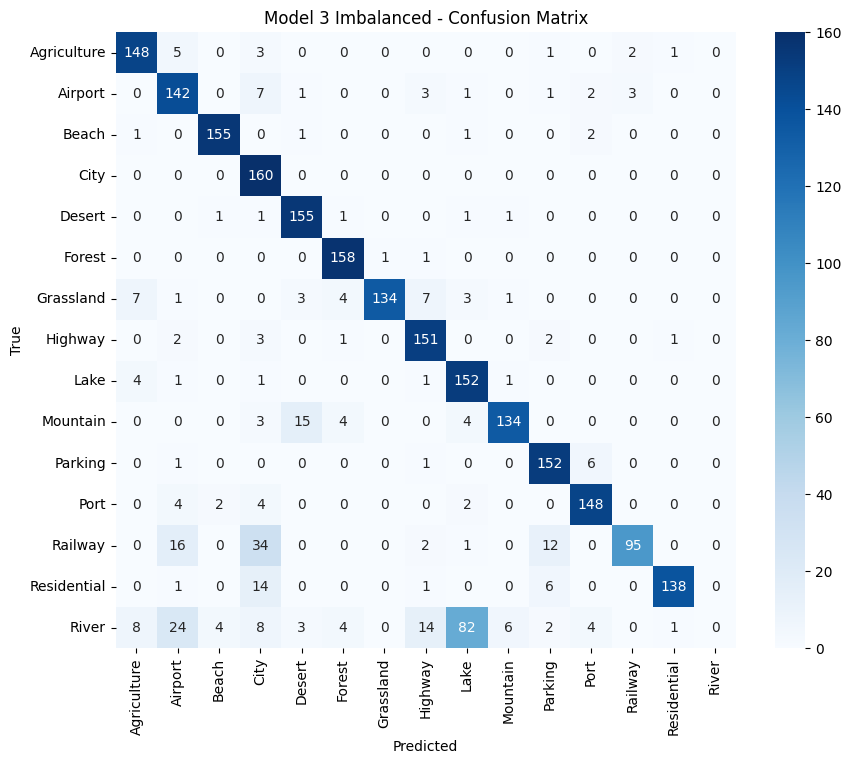

Model 3 Imbalanced: Accuracy=84.25%, F1=0.82, Precision=0.81, Recall=0.84, IoU=0.730, Train loss=0.101


In [26]:
# Model 3: MobileNetV3-Small, without CutMix
model3_imbalance = get_mobilenetv3_small(num_classes=15).to(device)
optimizer3_imbalance = optim.Adam(model3_imbalance.parameters(), lr=0.001)
print("Training Model 3 (MobileNetV3-Small, No CutMix) on imbalanced dataset...")
best_acc3_imbalance, training_time3_imbalance, train_loss3_imbalance = train_model(model3_imbalance, train_loader1_imbalance, test_loader_imbalance, criterion, optimizer3_imbalance, device, epochs=5, use_cutmix=False)

# Evaluate Model 3 on the test set (imbalanced)
acc3_imbalance, f1_3_imbalance, prec3_imbalance, rec3_imbalance, iou3_imbalance, preds3_imbalance, labels3_imbalance = evaluate_model(model3_imbalance, test_loader_imbalance, device, class_names=class_names, scenario="Model 3 Imbalanced", train_loss=train_loss3_imbalance)
print(f"Model 3 Imbalanced: Accuracy={acc3_imbalance:.2f}%, F1={f1_3_imbalance:.2f}, Precision={prec3_imbalance:.2f}, Recall={rec3_imbalance:.2f}, IoU={iou3_imbalance:.3f}, Train loss={train_loss3_imbalance:.3f}")

Training Model 4 (MobileNetV3-Small, With CutMix) on imbalanced dataset...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 0.9325, Train Accuracy: 81.14, Train IoU: 0.000, Test Accuracy: 71.42, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/5, Train loss: 0.6384, Train Accuracy: 95.04, Train IoU: 0.000, Test Accuracy: 81.88, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/5, Train loss: 0.4965, Train Accuracy: 95.06, Train IoU: 0.000, Test Accuracy: 83.79, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/5:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/5, Train loss: 0.6442, Train Accuracy: 94.58, Train IoU: 0.000, Test Accuracy: 84.12, Test IoU: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/5, Train loss: 0.5659, Train Accuracy: 97.91, Train IoU: 0.000, Test Accuracy: 86.08, Test IoU: 0.000
Best Test Accuracy: 86.08%
Training Time: 130.10 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Classification Report (Model 4 Imbalanced):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.855615  1.000000  0.922190   160.000000  0.855615    0.565921
Airport        0.834254  0.943750  0.885630   160.000000  0.794737    0.565921
Beach          0.890805  0.968750  0.928144   160.000000  0.865922    0.565921
City           0.751174  1.000000  0.857909   160.000000  0.751174    0.565921
Desert         0.967949  0.943750  0.955696   160.000000  0.915152    0.565921
Forest         0.900585  0.962500  0.930514   160.000000  0.870056    0.565921
Grassland      0.905882  0.962500  0.933333   160.000000  0.875000    0.565921
Highway        0.811224  0.993750  0.893258   160.000000  0.807107    0.565921
Lake           0.671053  0.956250  0.788660   160.000000  0.651064    0.565921
Mountain       0.770732  0.987500  0.865753   160.000000  0.763285    0.565921
Parking        0.987179  0.962500  0.974684   160.000000  0.950617    0.565921
Port    

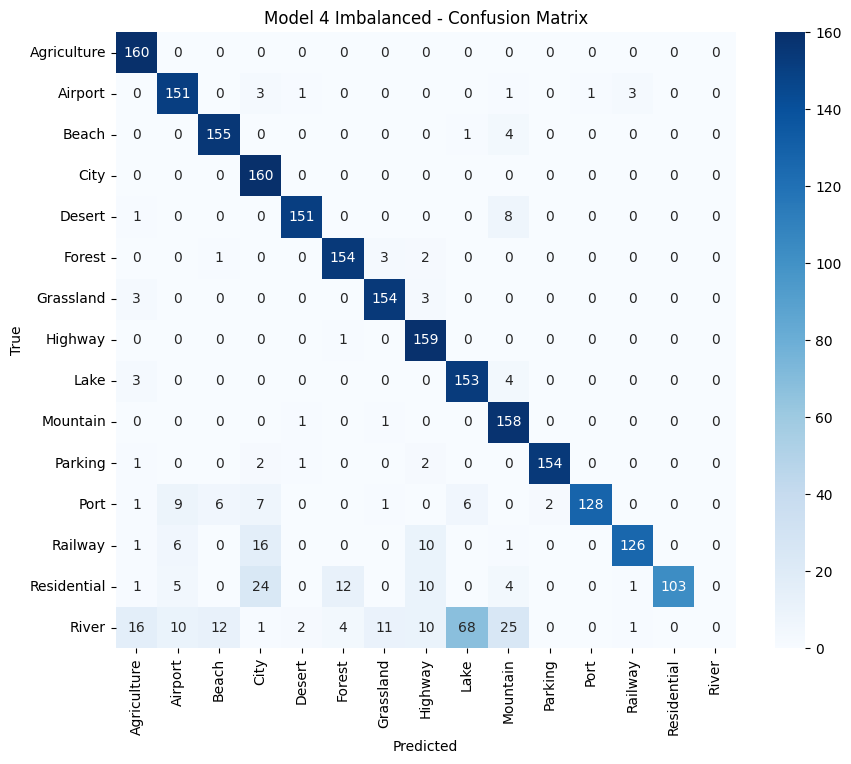

Model 4 Imbalanced: Accuracy=86.08%, F1=0.83, Precision=0.82, Recall=0.86, IoU=0.753, Train loss=0.566


In [27]:
# Model 4: MobileNetV3-Small, with CutMix
model4_imbalance = get_mobilenetv3_small(num_classes=15).to(device)
optimizer4_imbalance = optim.Adam(model4_imbalance.parameters(), lr=0.001)
print("Training Model 4 (MobileNetV3-Small, With CutMix) on imbalanced dataset...")
best_acc4_imbalance, training_time4_imbalance, train_loss4_imbalance = train_model(model4_imbalance, train_loader2_imbalance, test_loader_imbalance, criterion, optimizer4_imbalance, device, epochs=5, use_cutmix=True)

# Evaluate Model 4 on the test set (imbalanced)
acc4_imbalance, f1_4_imbalance, prec4_imbalance, rec4_imbalance, iou4_imbalance, preds4_imbalance, labels4_imbalance = evaluate_model(model4_imbalance, test_loader_imbalance, device, class_names=class_names, scenario="Model 4 Imbalanced", train_loss=train_loss4_imbalance)
print(f"Model 4 Imbalanced: Accuracy={acc4_imbalance:.2f}%, F1={f1_4_imbalance:.2f}, Precision={prec4_imbalance:.2f}, Recall={rec4_imbalance:.2f}, IoU={iou4_imbalance:.3f}, Train loss={train_loss4_imbalance:.3f}")


In [28]:
!ls

Aerial_Landscapes  __pycache__	src


In [29]:
from aerial_scorecam import get_scorecam_heatmap, get_batch_scorecam_heatmaps, overlay_heatmap_on_image

Step 3 Score-CAM


=== Score-CAM Visualization ===


100%|██████████| 32/32 [00:00<00:00, 174.09it/s]


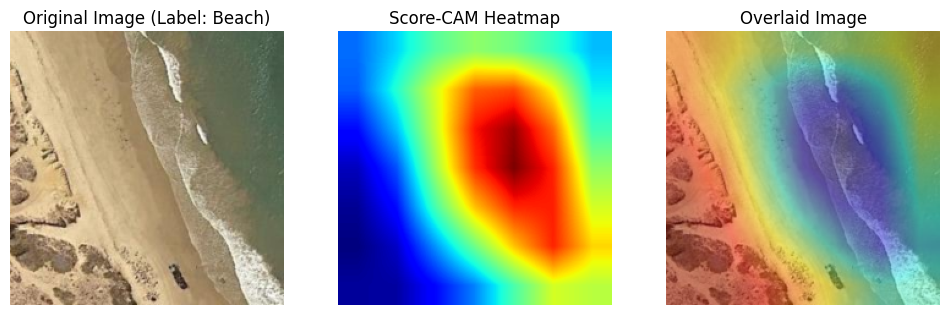

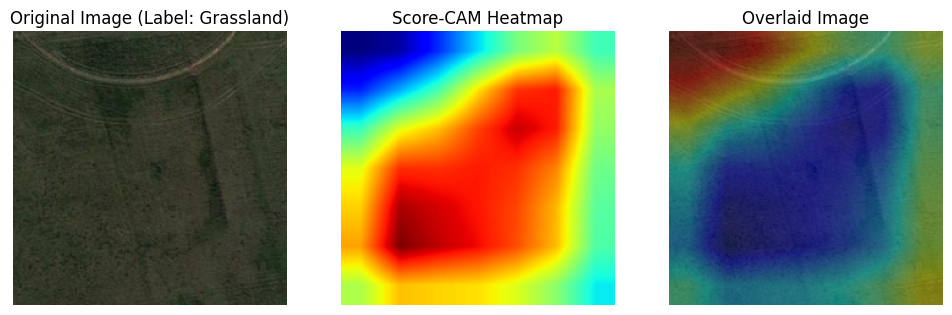

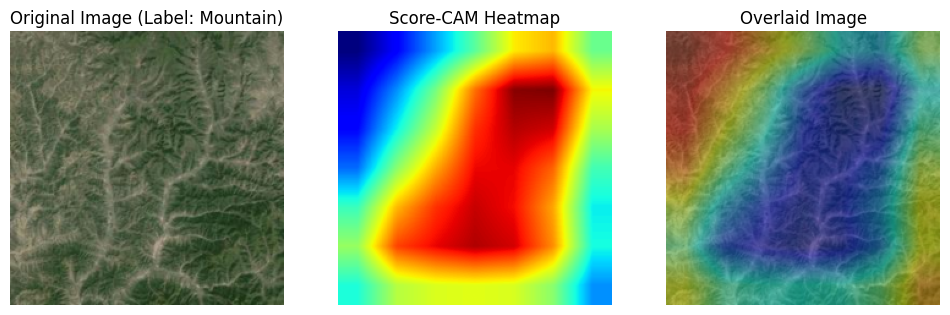

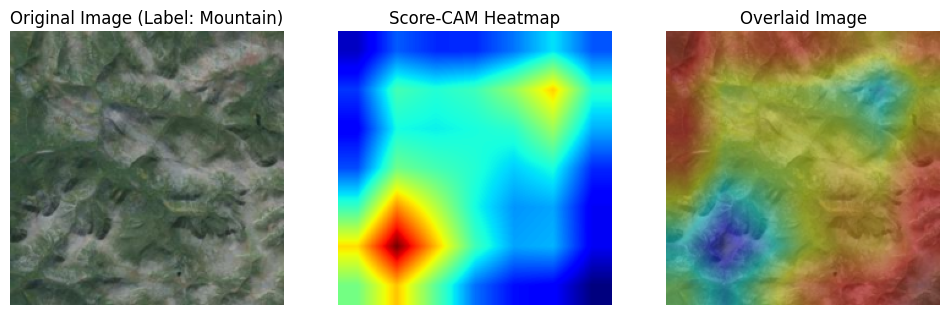

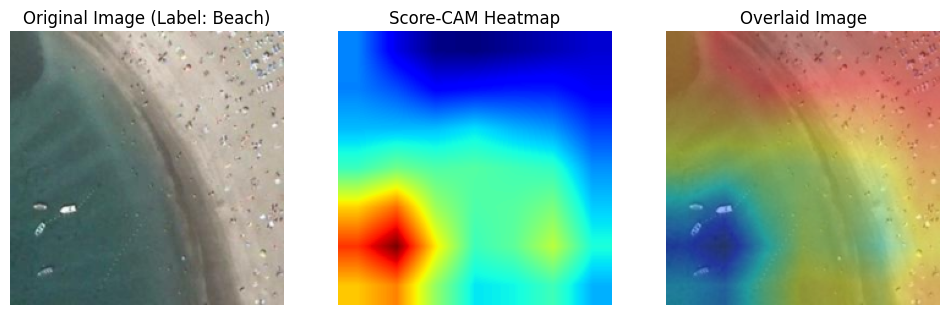

In [30]:
# Step 3: Score-CAM Visualization
print("\n=== Score-CAM Visualization ===")

# Select a batch of images from the test loader
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:5].to(device)  # Select first 5 images
sample_labels = sample_labels[:5].cpu().numpy()

# Generate heatmaps for the batch
target_layer = model1.layer4[-1]  # Specify the target layer for ResNet-18
heatmaps = get_batch_scorecam_heatmaps(model1, sample_images, target_layer, sample_labels)

# Plot heatmaps and overlaid images
for i in range(len(sample_images)):
    # Get the original image (denormalized)
    original_image = sample_images[i].cpu()
    # Denormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    original_image = original_image * std + mean  # Denormalize
    original_image = torch.clamp(original_image, 0, 1)  # Ensure values are in [0, 1]

    # Get the heatmap
    heatmap = heatmaps[i]

    # Overlay heatmap on the original image
    overlaid_image = overlay_heatmap_on_image(sample_images[i].cpu(), heatmap)

    # Plot the original image, heatmap, and overlaid image
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.permute(1, 2, 0).numpy())  # Show denormalized image
    plt.title(f"Original Image (Label: {class_names[sample_labels[i]]})")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Score-CAM Heatmap")
    plt.axis('off')

    # Overlaid image
    plt.subplot(1, 3, 3)
    plt.imshow(overlaid_image)
    plt.title(f"Overlaid Image")
    plt.axis('off')

    plt.show()

Step 4 Occlusion robustness test


Evaluating occlusion size 32px for Model 1...
Classification Report for Occlusion Test (Size 32):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.776119  0.975000  0.864266   160.000000  0.760976    0.251110
Airport        0.760870  0.656250  0.704698   160.000000  0.544041    0.251110
Beach          0.983051  0.725000  0.834532   160.000000  0.716049    0.251110
City           0.751323  0.887500  0.813754   160.000000  0.685990    0.251110
Desert         0.929487  0.906250  0.917722   160.000000  0.847953    0.251110
Forest         0.842391  0.968750  0.901163   160.000000  0.820106    0.251110
Grassland      0.890909  0.918750  0.904615   160.000000  0.825843    0.251110
Highway        0.924528  0.612500  0.736842   160.000000  0.583333    0.251110
Lake           0.888235  0.943750  0.915152   160.000000  0.843575    0.251110
Mountain       0.956522  0.412500  0.576419   160.000000  0.404908    0.251110
Parking        1.000000  0.80000

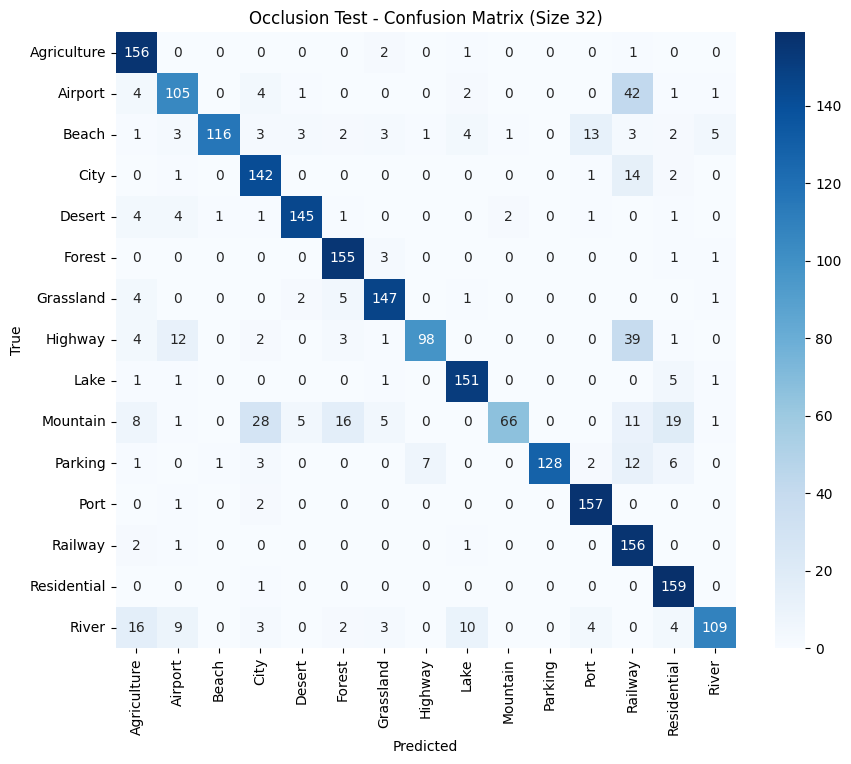

Model 1 - Occlusion 32px (Before vs After):
Accuracy: 85.58% (Before) -> 82.92% (After)
F1 Score: 0.85 (Before) -> 0.82 (After)
Precision: 0.88 (Before) -> 0.86 (After)
Recall: 0.86 (Before) -> 0.83 (After)
IoU: 0.754 (Before) -> 0.712 (After)
Train loss: 0.251

Evaluating occlusion size 32px for Model 2...
Classification Report for Occlusion Test (Size 32):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.956522  0.962500  0.959502   160.000000  0.922156    0.682777
Airport        0.801325  0.756250  0.778135   160.000000  0.636842    0.682777
Beach          0.972973  0.900000  0.935065   160.000000  0.878049    0.682777
City           0.950000  0.831250  0.886667   160.000000  0.796407    0.682777
Desert         0.947712  0.906250  0.926518   160.000000  0.863095    0.682777
Forest         0.955414  0.937500  0.946372   160.000000  0.898204    0.682777
Grassland      0.901163  0.968750  0.933735   160.000000  0.875706    0.682777
Highway

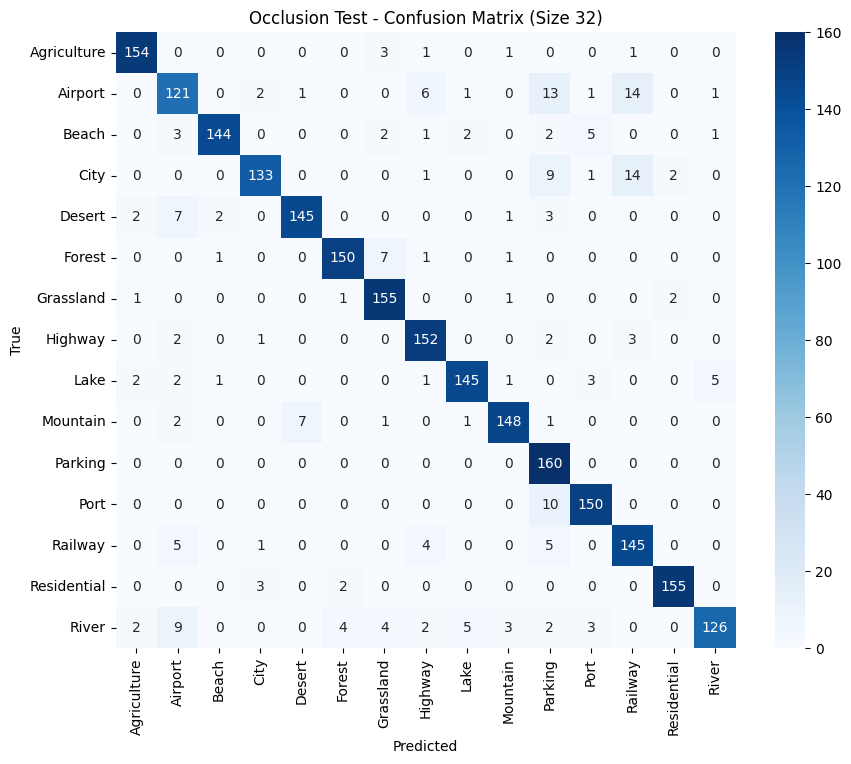

Model 2 - Occlusion 32px (Before vs After):
Accuracy: 91.71% (Before) -> 90.96% (After)
F1 Score: 0.92 (Before) -> 0.91 (After)
Precision: 0.92 (Before) -> 0.91 (After)
Recall: 0.92 (Before) -> 0.91 (After)
IoU: 0.849 (Before) -> 0.838 (After)
Train loss: 0.683

Evaluating occlusion size 32px for Model 3...
Classification Report for Occlusion Test (Size 32):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.898876  1.000000  0.946746   160.000000  0.898876    0.100708
Airport        0.905882  0.962500  0.933333   160.000000  0.875000    0.100708
Beach          0.992593  0.837500  0.908475   160.000000  0.832298    0.100708
City           0.956522  0.962500  0.959502   160.000000  0.922156    0.100708
Desert         0.987179  0.962500  0.974684   160.000000  0.950617    0.100708
Forest         0.960265  0.906250  0.932476   160.000000  0.873494    0.100708
Grassland      0.887006  0.981250  0.931751   160.000000  0.872222    0.100708
Highway

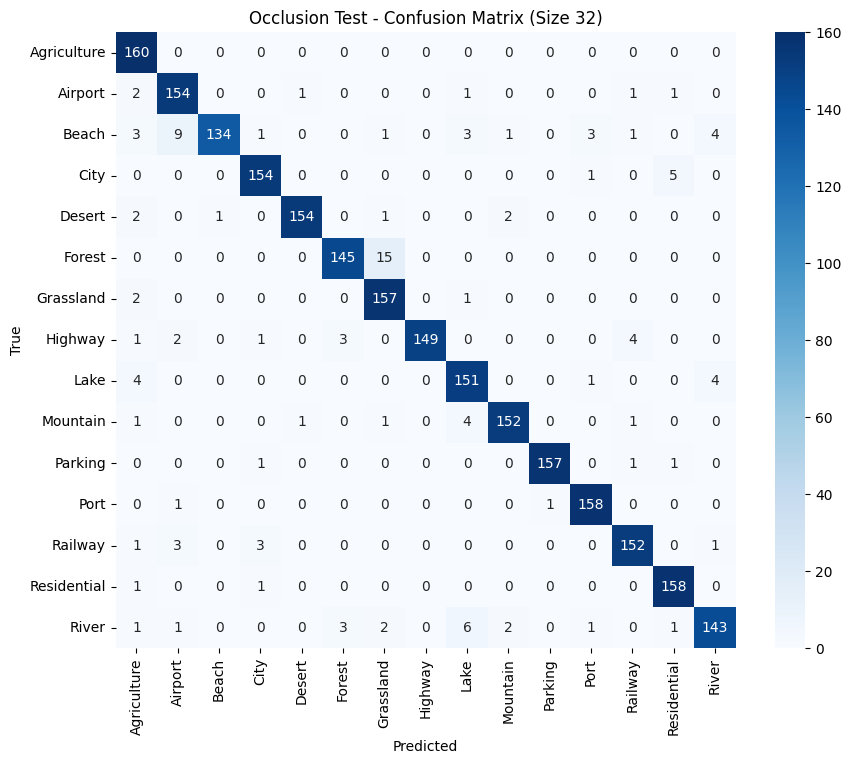

Model 3 - Occlusion 32px (Before vs After):
Accuracy: 95.12% (Before) -> 94.92% (After)
F1 Score: 0.95 (Before) -> 0.95 (After)
Precision: 0.95 (Before) -> 0.95 (After)
Recall: 0.95 (Before) -> 0.95 (After)
IoU: 0.908 (Before) -> 0.904 (After)
Train loss: 0.101

Evaluating occlusion size 32px for Model 4...
Classification Report for Occlusion Test (Size 32):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.882022  0.981250  0.928994   160.000000  0.867403    0.545421
Airport        0.902439  0.925000  0.913580   160.000000  0.840909    0.545421
Beach          0.969325  0.987500  0.978328   160.000000  0.957576    0.545421
City           0.962500  0.962500  0.962500   160.000000  0.927711    0.545421
Desert         0.859459  0.993750  0.921739   160.000000  0.854839    0.545421
Forest         0.935065  0.900000  0.917197   160.000000  0.847059    0.545421
Grassland      0.800000  0.975000  0.878873   160.000000  0.783920    0.545421
Highway

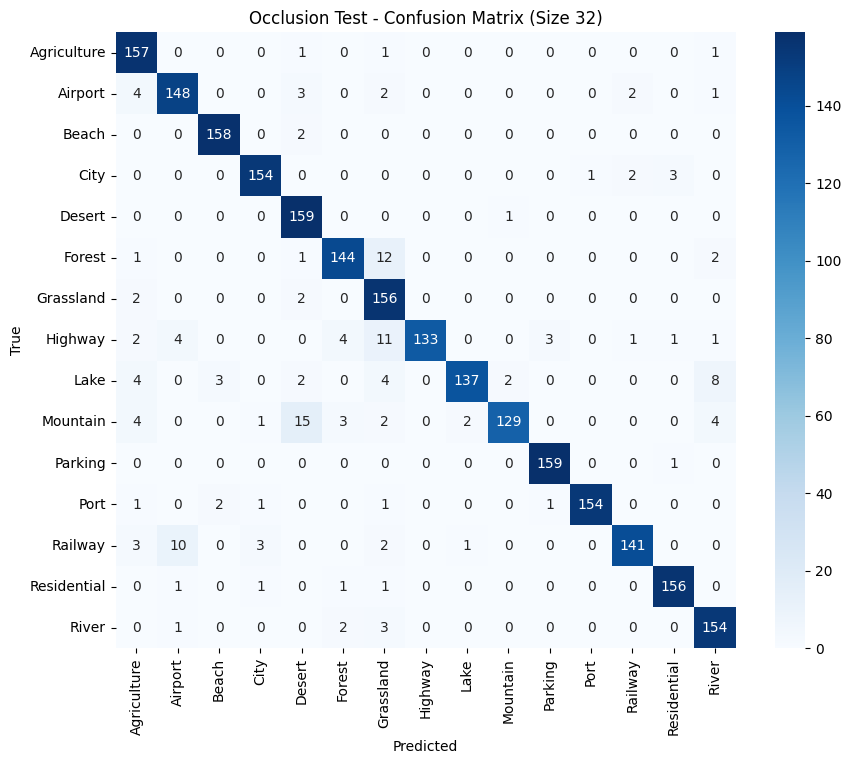

Model 4 - Occlusion 32px (Before vs After):
Accuracy: 93.33% (Before) -> 93.29% (After)
F1 Score: 0.93 (Before) -> 0.93 (After)
Precision: 0.94 (Before) -> 0.94 (After)
Recall: 0.93 (Before) -> 0.93 (After)
IoU: 0.878 (Before) -> 0.876 (After)
Train loss: 0.545

Evaluating occlusion size 64px for Model 1...
Classification Report for Occlusion Test (Size 64):
              precision   recall  f1-score     support       iou  train_loss
Agriculture    0.768041  0.93125  0.841808   160.00000  0.726829     0.25111
Airport        0.890000  0.55625  0.684615   160.00000  0.520468     0.25111
Beach          0.975610  0.50000  0.661157   160.00000  0.493827     0.25111
City           0.796512  0.85625  0.825301   160.00000  0.702564     0.25111
Desert         0.927273  0.31875  0.474419   160.00000  0.310976     0.25111
Forest         0.855491  0.92500  0.888889   160.00000  0.800000     0.25111
Grassland      0.913793  0.66250  0.768116   160.00000  0.623529     0.25111
Highway        0.850575

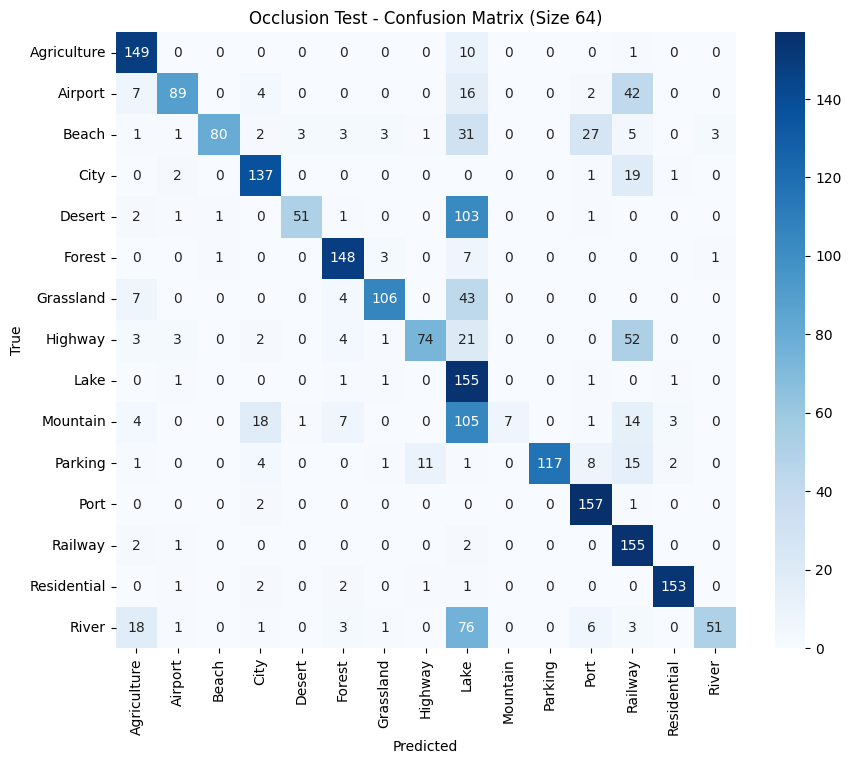

Model 1 - Occlusion 64px (Before vs After):
Accuracy: 85.58% (Before) -> 67.88% (After)
F1 Score: 0.85 (Before) -> 0.67 (After)
Precision: 0.88 (Before) -> 0.83 (After)
Recall: 0.86 (Before) -> 0.68 (After)
IoU: 0.754 (Before) -> 0.542 (After)
Train loss: 0.251

Evaluating occlusion size 64px for Model 2...
Classification Report for Occlusion Test (Size 64):
              precision   recall  f1-score     support       iou  train_loss
Agriculture    0.931677  0.93750  0.934579   160.00000  0.877193    0.682777
Airport        0.781457  0.73750  0.758842   160.00000  0.611399    0.682777
Beach          0.977941  0.83125  0.898649   160.00000  0.815951    0.682777
City           0.948529  0.80625  0.871622   160.00000  0.772455    0.682777
Desert         0.978261  0.84375  0.906040   160.00000  0.828221    0.682777
Forest         0.960265  0.90625  0.932476   160.00000  0.873494    0.682777
Grassland      0.929032  0.90000  0.914286   160.00000  0.842105    0.682777
Highway        0.861272

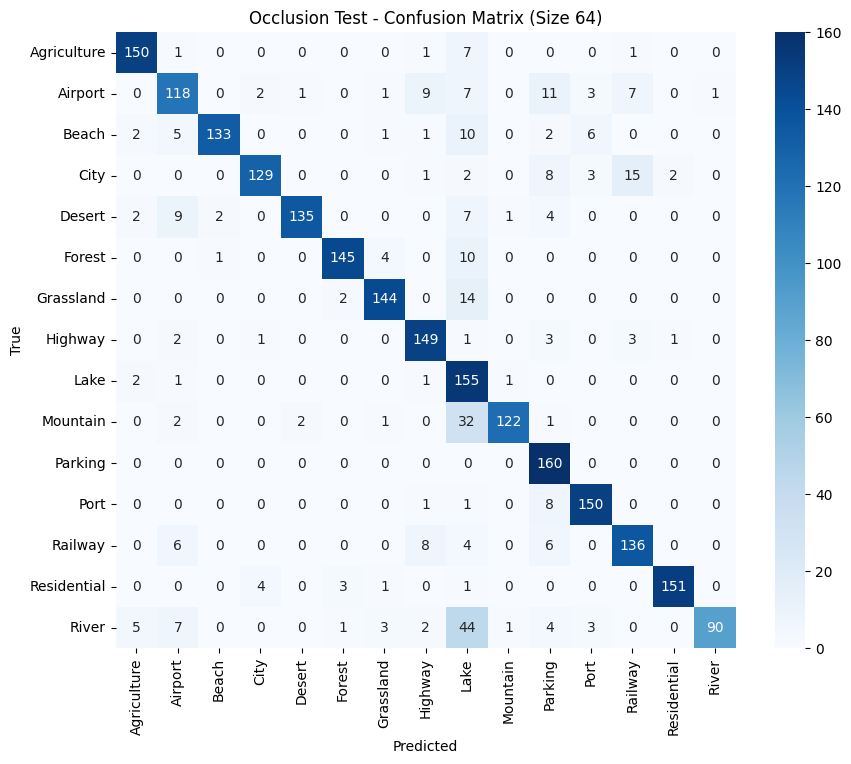

Model 2 - Occlusion 64px (Before vs After):
Accuracy: 91.71% (Before) -> 86.12% (After)
F1 Score: 0.92 (Before) -> 0.86 (After)
Precision: 0.92 (Before) -> 0.89 (After)
Recall: 0.92 (Before) -> 0.86 (After)
IoU: 0.849 (Before) -> 0.769 (After)
Train loss: 0.683

Evaluating occlusion size 64px for Model 3...
Classification Report for Occlusion Test (Size 64):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.881356  0.975000  0.925816   160.000000  0.861878    0.100708
Airport        0.925000  0.925000  0.925000   160.000000  0.860465    0.100708
Beach          1.000000  0.843750  0.915254   160.000000  0.843750    0.100708
City           0.955696  0.943750  0.949686   160.000000  0.904192    0.100708
Desert         0.968750  0.968750  0.968750   160.000000  0.939394    0.100708
Forest         0.959459  0.887500  0.922078   160.000000  0.855422    0.100708
Grassland      0.880682  0.968750  0.922619   160.000000  0.856354    0.100708
Highway

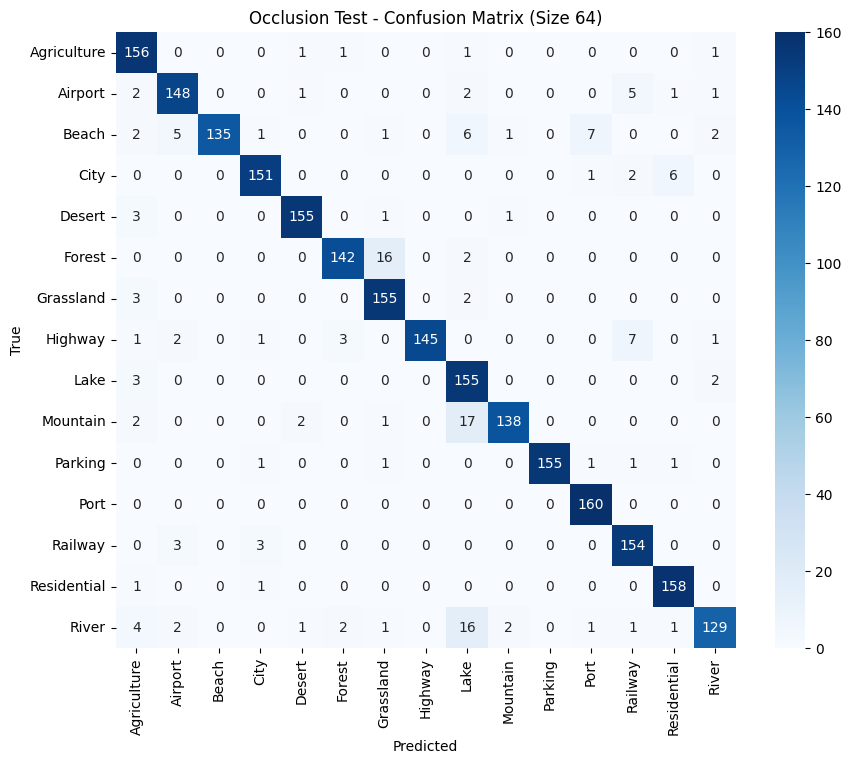

Model 3 - Occlusion 64px (Before vs After):
Accuracy: 95.12% (Before) -> 93.17% (After)
F1 Score: 0.95 (Before) -> 0.93 (After)
Precision: 0.95 (Before) -> 0.94 (After)
Recall: 0.95 (Before) -> 0.93 (After)
IoU: 0.908 (Before) -> 0.874 (After)
Train loss: 0.101

Evaluating occlusion size 64px for Model 4...
Classification Report for Occlusion Test (Size 64):
              precision   recall  f1-score  support       iou  train_loss
Agriculture    0.912791  0.98125  0.945783   160.00  0.897143    0.545421
Airport        0.879747  0.86875  0.874214   160.00  0.776536    0.545421
Beach          0.969512  0.99375  0.981481   160.00  0.963636    0.545421
City           0.950920  0.96875  0.959752   160.00  0.922619    0.545421
Desert         0.868852  0.99375  0.927114   160.00  0.864130    0.545421
Forest         0.945205  0.86250  0.901961   160.00  0.821429    0.545421
Grassland      0.763285  0.98750  0.861035   160.00  0.755981    0.545421
Highway        1.000000  0.73750  0.848921   16

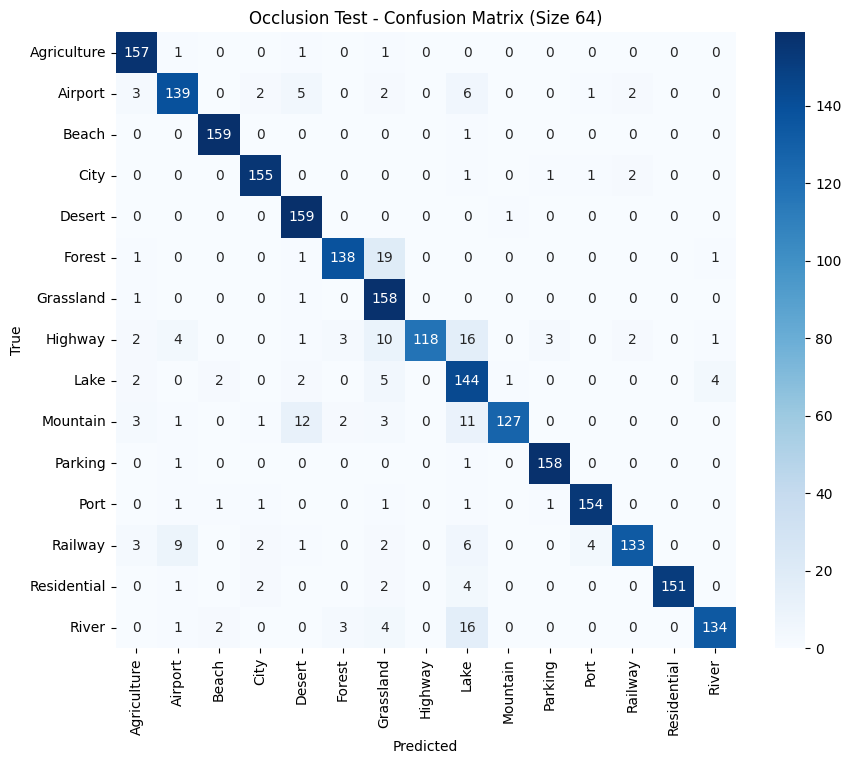

Model 4 - Occlusion 64px (Before vs After):
Accuracy: 93.33% (Before) -> 91.00% (After)
F1 Score: 0.93 (Before) -> 0.91 (After)
Precision: 0.94 (Before) -> 0.92 (After)
Recall: 0.93 (Before) -> 0.91 (After)
IoU: 0.878 (Before) -> 0.840 (After)
Train loss: 0.545

Evaluating occlusion size 96px for Model 1...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for Occlusion Test (Size 96):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.936364  0.643750  0.762963   160.000000  0.616766    0.251110
Airport        1.000000  0.131250  0.232044   160.000000  0.131250    0.251110
Beach          0.948718  0.231250  0.371859   160.000000  0.228395    0.251110
City           0.980000  0.612500  0.753846   160.000000  0.604938    0.251110
Desert         0.000000  0.000000  0.000000   160.000000  0.000000    0.251110
Forest         1.000000  0.356250  0.525346   160.000000  0.356250    0.251110
Grassland      1.000000  0.031250  0.060606   160.000000  0.031250    0.251110
Highway        0.812500  0.162500  0.270833   160.000000  0.156627    0.251110
Lake           0.108475  1.000000  0.195719   160.000000  0.108475    0.251110
Mountain       0.000000  0.000000  0.000000   160.000000  0.000000    0.251110
Parking        1.000000  0.512500  0.677686   160.000000  0.512500    0.251110


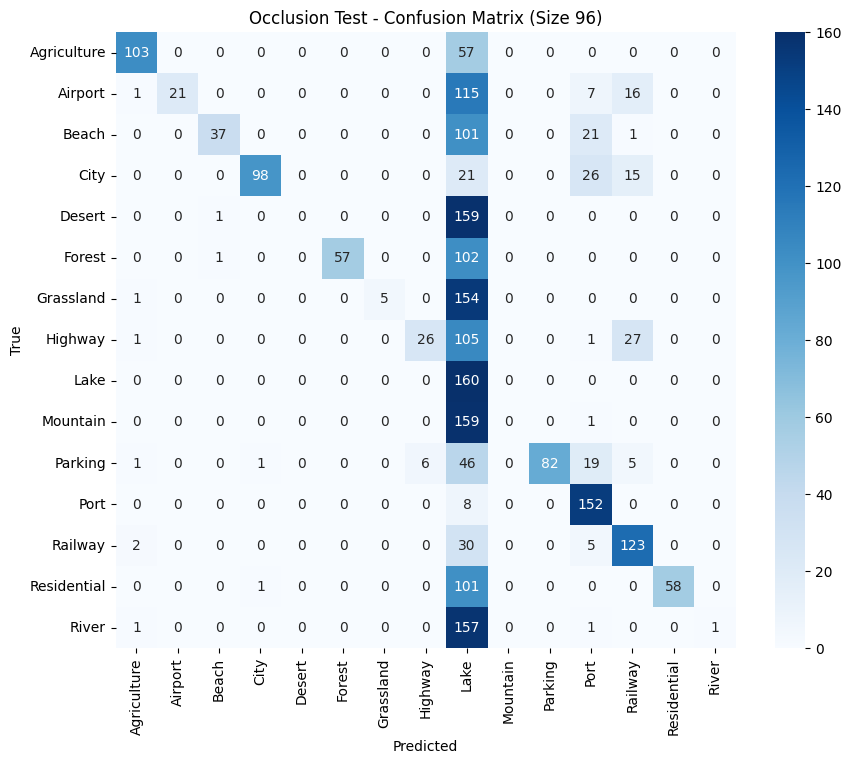

Model 1 - Occlusion 96px (Before vs After):
Accuracy: 85.58% (Before) -> 38.46% (After)
F1 Score: 0.85 (Before) -> 0.39 (After)
Precision: 0.88 (Before) -> 0.87 (After)
Recall: 0.86 (Before) -> 0.38 (After)
IoU: 0.754 (Before) -> 0.286 (After)
Train loss: 0.251

Evaluating occlusion size 96px for Model 2...
Classification Report for Occlusion Test (Size 96):
              precision   recall  f1-score     support       iou  train_loss
Agriculture    0.964789  0.85625  0.907285   160.00000  0.830303    0.682777
Airport        0.756098  0.58125  0.657244   160.00000  0.489474    0.682777
Beach          0.941667  0.70625  0.807143   160.00000  0.676647    0.682777
City           0.972222  0.65625  0.783582   160.00000  0.644172    0.682777
Desert         0.991071  0.69375  0.816176   160.00000  0.689441    0.682777
Forest         0.978261  0.84375  0.906040   160.00000  0.828221    0.682777
Grassland      0.931818  0.76875  0.842466   160.00000  0.727811    0.682777
Highway        0.902778

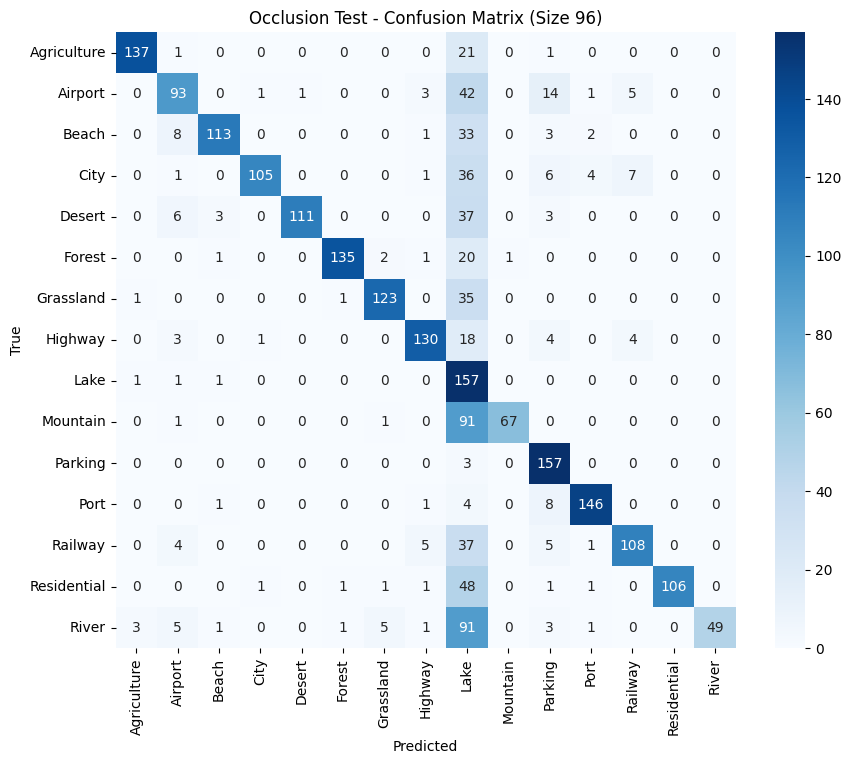

Model 2 - Occlusion 96px (Before vs After):
Accuracy: 91.71% (Before) -> 72.38% (After)
F1 Score: 0.92 (Before) -> 0.76 (After)
Precision: 0.92 (Before) -> 0.88 (After)
Recall: 0.92 (Before) -> 0.72 (After)
IoU: 0.849 (Before) -> 0.632 (After)
Train loss: 0.683

Evaluating occlusion size 96px for Model 3...
Classification Report for Occlusion Test (Size 96):
              precision    recall  f1-score      support       iou  train_loss
Agriculture    0.931973  0.856250  0.892508   160.000000  0.805882    0.100708
Airport        0.946970  0.781250  0.856164   160.000000  0.748503    0.100708
Beach          1.000000  0.787500  0.881119   160.000000  0.787500    0.100708
City           0.968000  0.756250  0.849123   160.000000  0.737805    0.100708
Desert         0.966887  0.912500  0.938907   160.000000  0.884848    0.100708
Forest         0.968421  0.575000  0.721569   160.000000  0.564417    0.100708
Grassland      0.879310  0.637500  0.739130   160.000000  0.586207    0.100708
Highway

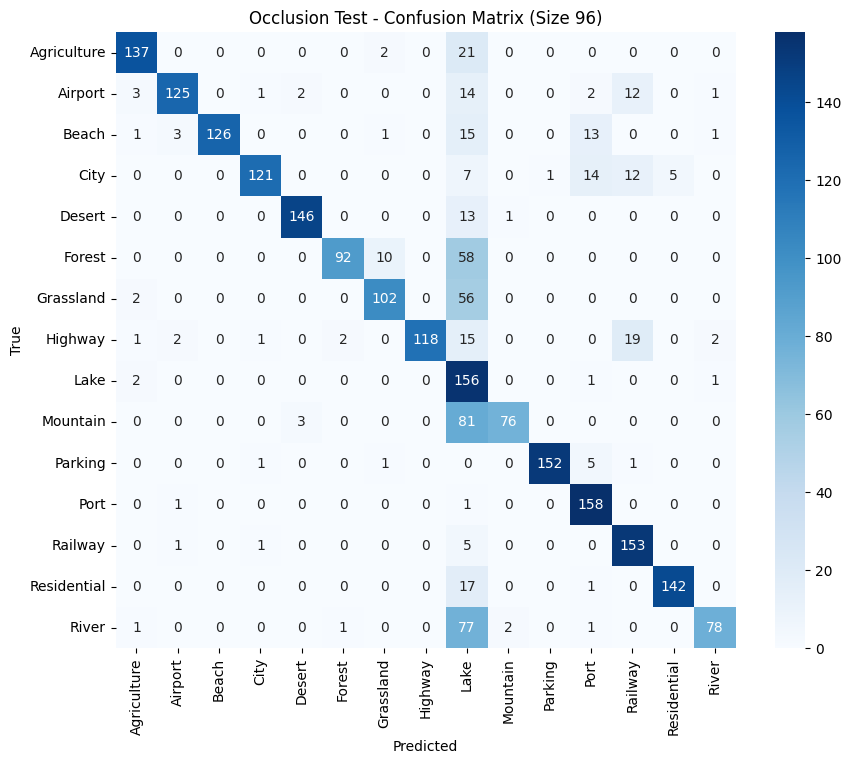

Model 3 - Occlusion 96px (Before vs After):
Accuracy: 95.12% (Before) -> 78.42% (After)
F1 Score: 0.95 (Before) -> 0.81 (After)
Precision: 0.95 (Before) -> 0.89 (After)
Recall: 0.95 (Before) -> 0.78 (After)
IoU: 0.908 (Before) -> 0.696 (After)
Train loss: 0.101

Evaluating occlusion size 96px for Model 4...
Classification Report for Occlusion Test (Size 96):
              precision   recall  f1-score     support       iou  train_loss
Agriculture    0.925000  0.92500  0.925000   160.00000  0.860465    0.545421
Airport        0.910959  0.83125  0.869281   160.00000  0.768786    0.545421
Beach          0.945455  0.97500  0.960000   160.00000  0.923077    0.545421
City           0.954248  0.91250  0.932907   160.00000  0.874251    0.545421
Desert         0.864130  0.99375  0.924419   160.00000  0.859459    0.545421
Forest         0.985816  0.86875  0.923588   160.00000  0.858025    0.545421
Grassland      0.824468  0.96875  0.890805   160.00000  0.803109    0.545421
Highway        1.000000

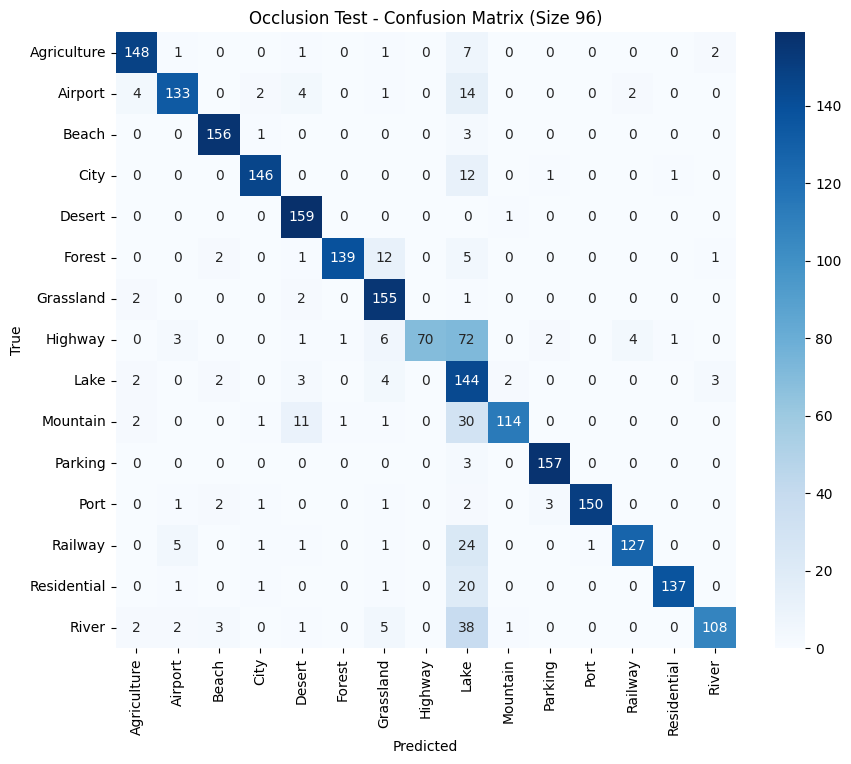

Model 4 - Occlusion 96px (Before vs After):
Accuracy: 93.33% (Before) -> 85.12% (After)
F1 Score: 0.93 (Before) -> 0.86 (After)
Precision: 0.94 (Before) -> 0.91 (After)
Recall: 0.93 (Before) -> 0.85 (After)
IoU: 0.878 (Before) -> 0.772 (After)
Train loss: 0.545


In [31]:
# Step 4: Occlusion Robustness Test (Test All Models)
occlusion_sizes = [32, 64, 96]
for size in occlusion_sizes:
    # Model 1 occlusion test
    print(f"\nEvaluating occlusion size {size}px for Model 1...")
    acc1_occ, f1_1_occ, prec1_occ, rec1_occ, iou1_occ = evaluate_with_occlusion(
        model1,
        test_loader,
        occlusion_size=size,
        device=device,
        class_names=class_names,
        train_loss=train_loss1
    )

    print(f"Model 1 - Occlusion {size}px (Before vs After):")
    print(f"Accuracy: {acc1_base:.2f}% (Before) -> {acc1_occ:.2f}% (After)")
    print(f"F1 Score: {f1_1_base:.2f} (Before) -> {f1_1_occ:.2f} (After)")
    print(f"Precision: {prec1_base:.2f} (Before) -> {prec1_occ:.2f} (After)")
    print(f"Recall: {rec1_base:.2f} (Before) -> {rec1_occ:.2f} (After)")
    print(f"IoU: {iou1_base:.3f} (Before) -> {iou1_occ:.3f} (After)")
    print(f"Train loss: {train_loss1:.3f}")
    all_results.append({
        "Model": "Model1 (ResNet-18, No CutMix)",
        "Best Test Accuracy": f"{best_acc1:.2f}%",
        "Occlusion Size": size,
        "Occlusion Accuracy": f"{acc1_occ:.2f}%",
        "Occlusion F1": f"{f1_1_occ:.3f}",
        "Occlusion Precision": f"{prec1_occ:.3f}",
        "Occlusion Recall": f"{rec1_occ:.3f}",
        "Occlusion IoU": f"{iou1_occ:.3f}",
        "Train loss": f"{train_loss1:.3f}",
        "Baseline Accuracy": f"{acc1_base:.2f}%",
        "Baseline F1": f"{f1_1_base:.3f}",
        "Baseline Precision": f"{prec1_base:.3f}",
        "Baseline Recall": f"{rec1_base:.3f}",
        "Baseline IoU": f"{iou1_base:.3f}",
        "TrainTime(s)": f"{training_time1:.1f}"
    })

    # Model 2 occlusion test
    print(f"\nEvaluating occlusion size {size}px for Model 2...")
    acc2_occ, f1_2_occ, prec2_occ, rec2_occ, iou2_occ = evaluate_with_occlusion(
        model2,
        test_loader,
        occlusion_size=size,
        device=device,
        class_names=class_names,
        train_loss=train_loss2
    )

    print(f"Model 2 - Occlusion {size}px (Before vs After):")
    print(f"Accuracy: {acc2_base:.2f}% (Before) -> {acc2_occ:.2f}% (After)")
    print(f"F1 Score: {f1_2_base:.2f} (Before) -> {f1_2_occ:.2f} (After)")
    print(f"Precision: {prec2_base:.2f} (Before) -> {prec2_occ:.2f} (After)")
    print(f"Recall: {rec2_base:.2f} (Before) -> {rec2_occ:.2f} (After)")
    print(f"IoU: {iou2_base:.3f} (Before) -> {iou2_occ:.3f} (After)")
    print(f"Train loss: {train_loss2:.3f}")
    all_results.append({
        "Model": "Model2 (ResNet-18, With CutMix)",
        "Best Test Accuracy": f"{best_acc2:.2f}%",
        "Occlusion Size": size,
        "Occlusion Accuracy": f"{acc2_occ:.2f}%",
        "Occlusion F1": f"{f1_2_occ:.3f}",
        "Occlusion Precision": f"{prec2_occ:.3f}",
        "Occlusion Recall": f"{rec2_occ:.3f}",
        "Occlusion IoU": f"{iou2_occ:.3f}",
        "Train loss": f"{train_loss2:.3f}",
        "Baseline Accuracy": f"{acc2_base:.2f}%",
        "Baseline F1": f"{f1_2_base:.3f}",
        "Baseline Precision": f"{prec2_base:.3f}",
        "Baseline Recall": f"{rec2_base:.3f}",
        "Baseline IoU": f"{iou2_base:.3f}",
        "TrainTime(s)": f"{training_time2:.1f}"
    })

    # Model 3 occlusion test
    print(f"\nEvaluating occlusion size {size}px for Model 3...")
    acc3_occ, f1_3_occ, prec3_occ, rec3_occ, iou3_occ = evaluate_with_occlusion(
        model3,
        test_loader,
        occlusion_size=size,
        device=device,
        class_names=class_names,
        train_loss=train_loss3
    )

    print(f"Model 3 - Occlusion {size}px (Before vs After):")
    print(f"Accuracy: {acc3_base:.2f}% (Before) -> {acc3_occ:.2f}% (After)")
    print(f"F1 Score: {f1_3_base:.2f} (Before) -> {f1_3_occ:.2f} (After)")
    print(f"Precision: {prec3_base:.2f} (Before) -> {prec3_occ:.2f} (After)")
    print(f"Recall: {rec3_base:.2f} (Before) -> {rec3_occ:.2f} (After)")
    print(f"IoU: {iou3_base:.3f} (Before) -> {iou3_occ:.3f} (After)")
    print(f"Train loss: {train_loss3:.3f}")
    all_results.append({
        "Model": "Model3 (MobileNetV3-Small, No CutMix)",
        "Best Test Accuracy": f"{best_acc3:.2f}%",
        "Occlusion Size": size,
        "Occlusion Accuracy": f"{acc3_occ:.2f}%",
        "Occlusion F1": f"{f1_3_occ:.3f}",
        "Occlusion Precision": f"{prec3_occ:.3f}",
        "Occlusion Recall": f"{rec3_occ:.3f}",
        "Occlusion IoU": f"{iou3_occ:.3f}",
        "Train loss": f"{train_loss3:.3f}",
        "Baseline Accuracy": f"{acc3_base:.2f}%",
        "Baseline F1": f"{f1_3_base:.3f}",
        "Baseline Precision": f"{prec3_base:.3f}",
        "Baseline Recall": f"{rec3_base:.3f}",
        "Baseline IoU": f"{iou3_base:.3f}",
        "TrainTime(s)": f"{training_time3:.1f}"
    })

    # Model 4 occlusion test
    print(f"\nEvaluating occlusion size {size}px for Model 4...")
    acc4_occ, f1_4_occ, prec4_occ, rec4_occ, iou4_occ = evaluate_with_occlusion(
        model4,
        test_loader,
        occlusion_size=size,
        device=device,
        class_names=class_names,
        train_loss=train_loss4
    )

    print(f"Model 4 - Occlusion {size}px (Before vs After):")
    print(f"Accuracy: {acc4_base:.2f}% (Before) -> {acc4_occ:.2f}% (After)")
    print(f"F1 Score: {f1_4_base:.2f} (Before) -> {f1_4_occ:.2f} (After)")
    print(f"Precision: {prec4_base:.2f} (Before) -> {prec4_occ:.2f} (After)")
    print(f"Recall: {rec4_base:.2f} (Before) -> {rec4_occ:.2f} (After)")
    print(f"IoU: {iou4_base:.3f} (Before) -> {iou4_occ:.3f} (After)")
    print(f"Train loss: {train_loss4:.3f}")
    all_results.append({
        "Model": "Model4 (MobileNetV3-Small, With CutMix)",
        "Best Test Accuracy": f"{best_acc4:.2f}%",
        "Occlusion Size": size,
        "Occlusion Accuracy": f"{acc4_occ:.2f}%",
        "Occlusion F1": f"{f1_4_occ:.3f}",
        "Occlusion Precision": f"{prec4_occ:.3f}",
        "Occlusion Recall": f"{rec4_occ:.3f}",
        "Occlusion IoU": f"{iou4_occ:.3f}",
        "Train loss": f"{train_loss4:.3f}",
        "Baseline Accuracy": f"{acc4_base:.2f}%",
        "Baseline F1": f"{f1_4_base:.3f}",
        "Baseline Precision": f"{prec4_base:.3f}",
        "Baseline Recall": f"{rec4_base:.3f}",
        "Baseline IoU": f"{iou4_base:.3f}",
        "TrainTime(s)": f"{training_time4:.1f}"
    })

In [32]:
import pandas as pd  # 新增 pandas 依赖

In [33]:
# Step 5: Summarize Results
print("\n=== Summary Table ===")

# Construct baseline results
baseline_results = [
    {
        "Scenario": "NormalData",
        "Model": "resnet18",
        "Accuracy": f"{acc1_base:.2f}%",
        "F1": f"{f1_1_base:.3f}",
        "Precision": f"{prec1_base:.3f}",
        "Recall": f"{rec1_base:.3f}",
        "IoU": f"{iou1_base:.3f}",
        "Train loss": f"{train_loss1:.3f}",
        "TrainTime(s)": f"{training_time1:.1f}"
    },
    {
        "Scenario": "NormalData",
        "Model": "resnet18_with_cutmix",
        "Accuracy": f"{acc2_base:.2f}%",
        "F1": f"{f1_2_base:.3f}",
        "Precision": f"{prec2_base:.3f}",
        "Recall": f"{rec2_base:.3f}",
        "IoU": f"{iou2_base:.3f}",
        "Train loss": f"{train_loss2:.3f}",
        "TrainTime(s)": f"{training_time2:.1f}"
    },
    {
        "Scenario": "NormalData",
        "Model": "mobilenet_v2",
        "Accuracy": f"{acc3_base:.2f}%",
        "F1": f"{f1_3_base:.3f}",
        "Precision": f"{prec3_base:.3f}",
        "Recall": f"{rec3_base:.3f}",
        "IoU": f"{iou3_base:.3f}",
        "Train loss": f"{train_loss3:.3f}",
        "TrainTime(s)": f"{training_time3:.1f}"
    },
    {
        "Scenario": "NormalData",
        "Model": "mobilenet_v2_with_cutmix",
        "Accuracy": f"{acc4_base:.2f}%",
        "F1": f"{f1_4_base:.3f}",
        "Precision": f"{prec4_base:.3f}",
        "Recall": f"{rec4_base:.3f}",
        "IoU": f"{iou4_base:.3f}",
        "Train loss": f"{train_loss4:.3f}",
        "TrainTime(s)": f"{training_time4:.1f}"
    },
    {
        "Scenario": "Imbalanced",
        "Model": "resnet18",
        "Accuracy": f"{acc1_imbalance:.2f}%",
        "F1": f"{f1_1_imbalance:.3f}",
        "Precision": f"{prec1_imbalance:.3f}",
        "Recall": f"{rec1_imbalance:.3f}",
        "IoU": f"{iou1_imbalance:.3f}",
        "Train loss": f"{train_loss1_imbalance:.3f}",
        "TrainTime(s)": f"{training_time1_imbalance:.1f}"
    },
    {
        "Scenario": "Imbalanced",
        "Model": "resnet18_with_cutmix",
        "Accuracy": f"{acc2_imbalance:.2f}%",
        "F1": f"{f1_2_imbalance:.3f}",
        "Precision": f"{prec2_imbalance:.3f}",
        "Recall": f"{rec2_imbalance:.3f}",
        "IoU": f"{iou2_imbalance:.3f}",
        "Train loss": f"{train_loss2_imbalance:.3f}",
        "TrainTime(s)": f"{training_time2_imbalance:.1f}"
    },
    {
        "Scenario": "Imbalanced",
        "Model": "mobilenet_v2",
        "Accuracy": f"{acc3_imbalance:.2f}%",
        "F1": f"{f1_3_imbalance:.3f}",
        "Precision": f"{prec3_imbalance:.3f}",
        "Recall": f"{rec3_imbalance:.3f}",
        "IoU": f"{iou3_imbalance:.3f}",
        "Train loss": f"{train_loss3_imbalance:.3f}",
        "TrainTime(s)": f"{training_time3_imbalance:.1f}"
    },
    {
        "Scenario": "Imbalanced",
        "Model": "mobilenet_v2_with_cutmix",
        "Accuracy": f"{acc4_imbalance:.2f}%",
        "F1": f"{f1_4_imbalance:.3f}",
        "Precision": f"{prec4_imbalance:.3f}",
        "Recall": f"{rec4_imbalance:.3f}",
        "IoU": f"{iou4_imbalance:.3f}",
        "Train loss": f"{train_loss4_imbalance:.3f}",
        "TrainTime(s)": f"{training_time4_imbalance:.1f}"
    }
]

# Add occlusion test results
all_results = baseline_results + [
    {
        "Scenario": f"OcclusionTest_NORMAL_ResNet",
        "Model": "resnet18",
        "Accuracy": result["Occlusion Accuracy"],
        "F1": result["Occlusion F1"],
        "Precision": result["Occlusion Precision"],
        "Recall": result["Occlusion Recall"],
        "IoU": result["Occlusion IoU"],
        "Train loss": result["Train loss"],
        "TrainTime(s)": result["TrainTime(s)"]
    } for result in all_results if result["Model"] == "Model1 (ResNet-18, No CutMix)"
] + [
    {
        "Scenario": f"OcclusionTest_NORMAL_ResNet",
        "Model": "resnet18_with_cutmix",
        "Accuracy": result["Occlusion Accuracy"],
        "F1": result["Occlusion F1"],
        "Precision": result["Occlusion Precision"],
        "Recall": result["Occlusion Recall"],
        "IoU": result["Occlusion IoU"],
        "Train loss": result["Train loss"],
        "TrainTime(s)": result["TrainTime(s)"]
    } for result in all_results if result["Model"] == "Model2 (ResNet-18, With CutMix)"
] + [
    {
        "Scenario": f"OcclusionTest_NORMAL_MobileNet",
        "Model": "mobilenet_v2",
        "Accuracy": result["Occlusion Accuracy"],
        "F1": result["Occlusion F1"],
        "Precision": result["Occlusion Precision"],
        "Recall": result["Occlusion Recall"],
        "IoU": result["Occlusion IoU"],
        "Train loss": result["Train loss"],
        "TrainTime(s)": result["TrainTime(s)"]
    } for result in all_results if result["Model"] == "Model3 (MobileNetV3-Small, No CutMix)"
] + [
    {
        "Scenario": f"OcclusionTest_NORMAL_MobileNet",
        "Model": "mobilenet_v2_with_cutmix",
        "Accuracy": result["Occlusion Accuracy"],
        "F1": result["Occlusion F1"],
        "Precision": result["Occlusion Precision"],
        "Recall": result["Occlusion Recall"],
        "IoU": result["Occlusion IoU"],
        "Train loss": result["Train loss"],
        "TrainTime(s)": result["TrainTime(s)"]
    } for result in all_results if result["Model"] == "Model4 (MobileNetV3-Small, With CutMix)"
]

# Convert to DataFrame
df_all = pd.DataFrame(all_results)

# Print full results
print(df_all)

# Print in Markdown format
print("\n=== Summary Table ===")
print(df_all.to_markdown(index=False))


=== Summary Table ===
                          Scenario                     Model Accuracy     F1  \
0                       NormalData                  resnet18   85.58%  0.854   
1                       NormalData      resnet18_with_cutmix   91.71%  0.917   
2                       NormalData              mobilenet_v2   95.12%  0.951   
3                       NormalData  mobilenet_v2_with_cutmix   93.33%  0.934   
4                       Imbalanced                  resnet18   84.38%  0.816   
5                       Imbalanced      resnet18_with_cutmix   78.21%  0.753   
6                       Imbalanced              mobilenet_v2   84.25%  0.815   
7                       Imbalanced  mobilenet_v2_with_cutmix   86.08%  0.831   
8      OcclusionTest_NORMAL_ResNet                  resnet18   82.92%  0.824   
9      OcclusionTest_NORMAL_ResNet                  resnet18   67.88%  0.670   
10     OcclusionTest_NORMAL_ResNet                  resnet18   38.46%  0.392   
11     OcclusionT

In [ ]:
# Save to CSV
df_all.to_csv("final_comparison.csv", index=False)
print("ALL experiments completed. Results saved in final_comparison.csv.")

ALL experiments completed. Results saved in final_comparison.csv.
